In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from keras.preprocessing.sequence import TimeseriesGenerator
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from math import sqrt
import warnings

warnings.filterwarnings("ignore")

In [20]:
df = pd.read_csv('C:/Users/shail/Desktop/project/raw data/Device-3.csv')

df.columns = ['SNo','temp','hum','co','no2','pm2_5','pm10','date']
date = df['date']
df = df.drop(["SNo"],axis=1)
df['date'] = pd.to_datetime(df['date'])

In [21]:
df.head()

,temp,hum,co,no2,pm2_5,pm10,date
0,14,49,43,1.24,68,95,2020-01-11 17:08:37
1,14,49,43,1.22,68,95,2020-01-11 17:08:19
2,14,49,43,1.20,70,97,2020-01-11 17:07:39
3,14,49,43,1.18,70,97,2020-01-11 17:07:25
4,14,49,43,1.18,70,97,2020-01-11 17:06:55


In [22]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1096922 entries, 0 to 1096921
Data columns (total 7 columns):
 #   Column  Non-Null Count    Dtype         
---  ------  --------------    -----         
 0   temp    1096922 non-null  int64         
 1   hum     1096922 non-null  int64         
 2   co      1096922 non-null  int64         
 3   no2     1096922 non-null  float64       
 4   pm2_5   1096922 non-null  int64         
 5   pm10    1096922 non-null  int64         
 6   date    1096922 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(1), int64(5)
memory usage: 58.6 MB


In [23]:
df = df[(df['co'] > 0) & (df['no2'] > 0) & (df['pm2_5'] > 0) & (df['pm10'] > 0)]

In [24]:
temp_one_hr = round(df.resample('60min',on='date').temp.mean(),2)
hum_one_hr = round(df.resample('60min',on='date').hum.mean(),2)
co_one_hr = round(df.resample('60min',on='date').co.mean(),2)
no2_one_hr = round(df.resample('60min',on='date').no2.mean(),2)
pm2_5_one_hr = round(df.resample('60min',on='date').pm2_5.mean(),2)
pm10_one_hr = round(df.resample('60min',on='date').pm10.mean(),2)

one_hr_sample = pd.DataFrame({
    "TEMP":temp_one_hr,
    "HUM":hum_one_hr,
    "CO":co_one_hr,
    "NO2":no2_one_hr,
    "PM2.5":pm2_5_one_hr,
    "PM10":pm10_one_hr
})

one_hr_sample

,TEMP,HUM,CO,NO2,PM2.5,PM10
date,,,,,,
2019-09-13 16:00:00,17.69,61.16,6.32,19.40,32.73,45.76
2019-09-13 17:00:00,16.80,67.48,6.43,19.40,38.32,53.31
2019-09-13 18:00:00,17.00,66.82,6.21,19.40,27.65,38.68
2019-09-13 19:00:00,16.40,63.55,5.78,19.39,22.28,31.30
2019-09-13 20:00:00,15.73,66.26,6.06,19.39,22.89,31.97
...,...,...,...,...,...,...
2020-01-11 13:00:00,23.58,28.62,41.87,1.08,93.57,130.05
2020-01-11 14:00:00,23.81,25.91,42.29,1.07,71.30,99.06
2020-01-11 15:00:00,19.66,33.67,43.16,1.30,68.58,95.50


In [25]:
pm = one_hr_sample[['PM2.5']].copy()

In [26]:
pm

,PM2.5
date,
2019-09-13 16:00:00,32.73
2019-09-13 17:00:00,38.32
2019-09-13 18:00:00,27.65
2019-09-13 19:00:00,22.28
2019-09-13 20:00:00,22.89
...,...
2020-01-11 13:00:00,93.57
2020-01-11 14:00:00,71.30
2020-01-11 15:00:00,68.58


In [27]:
df = pm.copy()

In [28]:
df = df[-744:]
df

,PM2.5
date,
2019-12-11 18:00:00,NaN
2019-12-11 19:00:00,NaN
2019-12-11 20:00:00,NaN
2019-12-11 21:00:00,NaN
2019-12-11 22:00:00,NaN
...,...
2020-01-11 13:00:00,93.57
2020-01-11 14:00:00,71.30
2020-01-11 15:00:00,68.58


In [29]:
df.isna().sum()

PM2.5    276
dtype: int64

In [30]:
df = df.interpolate(method ='linear', limit_direction='both')

<AxesSubplot:xlabel='date'>

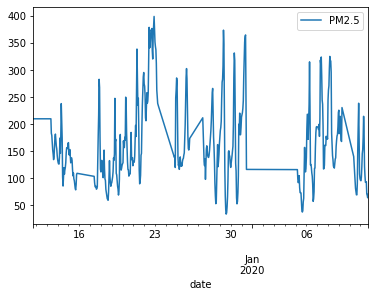

In [31]:
df.plot()

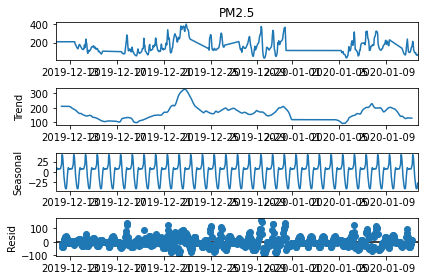

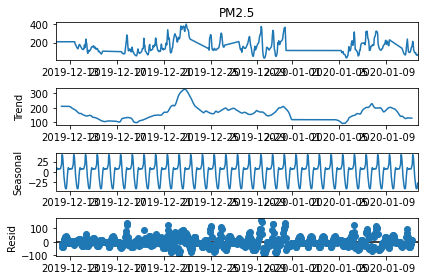

In [32]:
results = seasonal_decompose(df['PM2.5'], freq=24)
results.plot()

In [33]:
len(df)

744

In [34]:
train = df.iloc[:720]
test = df.iloc[720:]

scaler = MinMaxScaler()

In [35]:
df.head(), df.tail()

(                      PM2.5
 date                       
 2019-12-11 18:00:00  209.72
 2019-12-11 19:00:00  209.72
 2019-12-11 20:00:00  209.72
 2019-12-11 21:00:00  209.72
 2019-12-11 22:00:00  209.72,
                      PM2.5
 date                      
 2020-01-11 13:00:00  93.57
 2020-01-11 14:00:00  71.30
 2020-01-11 15:00:00  68.58
 2020-01-11 16:00:00  64.05
 2020-01-11 17:00:00  70.56)

In [36]:
scaler.fit(train)
scaled_train = scaler.transform(train)
scaled_test = scaler.transform(test)

scaled_train[:10]

array([[0.48221777],
       [0.48221777],
       [0.48221777],
       [0.48221777],
       [0.48221777],
       [0.48221777],
       [0.48221777],
       [0.48221777],
       [0.48221777],
       [0.48221777]])

# Recursive Strategy

In [37]:
n_input = 24
n_features = 1
generator = TimeseriesGenerator(scaled_train, scaled_train,length=n_input,batch_size=1)

generator[0]

(array([[[0.48221777],
         [0.48221777],
         [0.48221777],
         [0.48221777],
         [0.48221777],
         [0.48221777],
         [0.48221777],
         [0.48221777],
         [0.48221777],
         [0.48221777],
         [0.48221777],
         [0.48221777],
         [0.48221777],
         [0.48221777],
         [0.48221777],
         [0.48221777],
         [0.48221777],
         [0.48221777],
         [0.48221777],
         [0.48221777],
         [0.48221777],
         [0.48221777],
         [0.48221777],
         [0.48221777]]]),
 array([[0.48221777]]))

In [38]:
model = Sequential()
model.add(LSTM(200, activation='relu', input_shape=(n_input, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 200)               161600    
_________________________________________________________________
dense (Dense)                (None, 1)                 201       
Total params: 161,801
Trainable params: 161,801
Non-trainable params: 0
_________________________________________________________________


In [39]:
model.fit(generator, epochs=10, verbose=1)

Epoch 1/10
696/696 [==============================] - 80s 26ms/step - loss: 0.0205
Epoch 2/10
696/696 [==============================] - 17s 24ms/step - loss: 0.0084
Epoch 3/10
696/696 [==============================] - 10s 14ms/step - loss: 0.0058
Epoch 4/10
696/696 [==============================] - 12s 17ms/step - loss: 0.0051
Epoch 5/10
696/696 [==============================] - 11s 15ms/step - loss: 0.0042
Epoch 6/10
696/696 [==============================] - 11s 15ms/step - loss: 0.0049
Epoch 7/10
696/696 [==============================] - 12s 17ms/step - loss: 0.0038
Epoch 8/10
696/696 [==============================] - 12s 17ms/step - loss: 0.0052
Epoch 9/10
696/696 [==============================] - 12s 17ms/step - loss: 0.0042
Epoch 10/10
696/696 [==============================] - 18s 26ms/step - loss: 0.0036


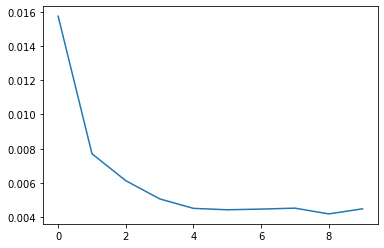

In [40]:
loss_per_epoch = model.history.history['loss']
plt.plot(range(len(loss_per_epoch)), loss_per_epoch)

In [41]:
last_train_batch = scaled_train[-n_input:]

last_train_batch = last_train_batch.reshape((1,n_input, n_features))

model.predict(last_train_batch)

array([[0.19666964]], dtype=float32)

In [42]:
scaled_test[0], scaled_test[1]

(array([0.32619485]), array([0.45487949]))

In [43]:
test_predictions = []

first_eval_batch = scaled_train[-n_input:]
current_batch = first_eval_batch.reshape((1, n_input, n_features))

for i in range(len(test)):
    current_pred = model.predict(current_batch)[0]
    
    test_predictions.append(current_pred)
    
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]], axis=1)
    
test_predictions

[array([0.19666964], dtype=float32),
 array([0.23163569], dtype=float32),
 array([0.26238057], dtype=float32),
 array([0.28718626], dtype=float32),
 array([0.30547452], dtype=float32),
 array([0.3174287], dtype=float32),
 array([0.3238468], dtype=float32),
 array([0.32592192], dtype=float32),
 array([0.32499537], dtype=float32),
 array([0.32230783], dtype=float32),
 array([0.31891382], dtype=float32),
 array([0.3155864], dtype=float32),
 array([0.31282204], dtype=float32),
 array([0.3108448], dtype=float32),
 array([0.3096721], dtype=float32),
 array([0.30919966], dtype=float32),
 array([0.30925792], dtype=float32),
 array([0.3096691], dtype=float32),
 array([0.31028435], dtype=float32),
 array([0.31097507], dtype=float32),
 array([0.3116426], dtype=float32),
 array([0.31222203], dtype=float32),
 array([0.3126816], dtype=float32),
 array([0.31301513], dtype=float32)]

In [44]:
test.head()

,PM2.5
date,
2020-01-10 18:00:00,152.82
2020-01-10 19:00:00,199.75
2020-01-10 20:00:00,238.45
2020-01-10 21:00:00,173.36
2020-01-10 22:00:00,107.83


In [45]:
true_predictions = scaler.inverse_transform(test_predictions)

test['recursive_predict'] = true_predictions

<AxesSubplot:xlabel='date'>

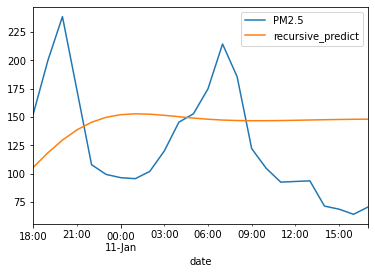

In [46]:
test.plot()

In [47]:
rmse = sqrt(mean_squared_error(test['PM2.5'], test['recursive_predict']))
print(rmse)

57.28138240378495


In [48]:
test

,PM2.5,recursive_predict
date,,
2020-01-10 18:00:00,152.82,105.583450
2020-01-10 19:00:00,199.75,118.335220
2020-01-10 20:00:00,238.45,129.547570
2020-01-10 21:00:00,173.36,138.593959
2020-01-10 22:00:00,107.83,145.263503
2020-01-10 23:00:00,99.25,149.623076
2020-01-11 00:00:00,96.39,151.963685
2020-01-11 01:00:00,95.48,152.720466
2020-01-11 02:00:00,101.92,152.382561


# Direct Startegy

In [49]:
def generate_data(data, n_input, month):
    X, y = [], []
    for i in range(0,len(data)-(n_input+month)):
            X.append(data[i:i+n_input])
            y.append(data[i+n_input+(month-1)])
    return np.array(X), np.array(y)

In [50]:
def model_predict(m_no, train_data, n_input, n_features):
    
    model = Sequential()
    model.add(LSTM(200, activation='relu', input_shape=(n_input, n_features)))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    
    X, y = generate_data(train_data, n_input, m_no)
    
    #print("MODEL : ", m_no)
    #print(X[0], y[0])
    
    model.fit(X, y, epochs=3, verbose=0)
    
    tX = train_data[-n_input:]
    
    tX = tX.reshape((1, n_input, n_features))
    
    res = model.predict(tX)
    
    return res[0]

In [51]:
n_input = 24
n_features = 1
test_predictions = []

for i in range(len(scaled_test)):
    test_predictions.append(model_predict(i+1,scaled_train,n_input, n_features))
    
test_predictions

[array([0.22042194], dtype=float32),
 array([0.23333642], dtype=float32),
 array([0.261517], dtype=float32),
 array([0.25187048], dtype=float32),
 array([0.25267157], dtype=float32),
 array([0.22953513], dtype=float32),
 array([0.27166337], dtype=float32),
 array([0.3072129], dtype=float32),
 array([0.27493113], dtype=float32),
 array([0.25255126], dtype=float32),
 array([0.25506714], dtype=float32),
 array([0.25862727], dtype=float32),
 array([0.27384382], dtype=float32),
 array([0.2720268], dtype=float32),
 array([0.30128428], dtype=float32),
 array([0.2445547], dtype=float32),
 array([0.29013294], dtype=float32),
 array([0.27117035], dtype=float32),
 array([0.23529252], dtype=float32),
 array([0.26365227], dtype=float32),
 array([0.26575094], dtype=float32),
 array([0.2607933], dtype=float32),
 array([0.23446308], dtype=float32),
 array([0.30083036], dtype=float32)]

In [52]:
true_predictions = scaler.inverse_transform(test_predictions)

test['direct_predict'] = true_predictions

<AxesSubplot:xlabel='date'>

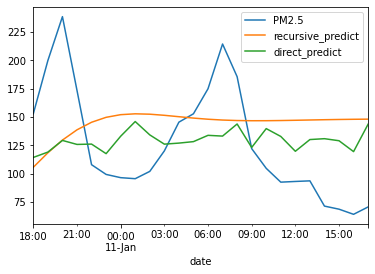

In [53]:
test.plot()

In [54]:
rmse = sqrt(mean_squared_error(test['PM2.5'], test['direct_predict']))
print(rmse)

49.69697599678672


In [55]:
test

,PM2.5,recursive_predict,direct_predict
date,,,
2020-01-10 18:00:00,152.82,105.583450,114.245677
2020-01-10 19:00:00,199.75,118.335220,118.955459
2020-01-10 20:00:00,238.45,129.547570,129.232630
2020-01-10 21:00:00,173.36,138.593959,125.714647
2020-01-10 22:00:00,107.83,145.263503,126.006795
2020-01-10 23:00:00,99.25,149.623076,117.569168
2020-01-11 00:00:00,96.39,151.963685,132.932914
2020-01-11 01:00:00,95.48,152.720466,145.897469
2020-01-11 02:00:00,101.92,152.382561,134.124635


# Direct Recursive Startegy

In [56]:
def generate_data(data, n_input, month):
    X, y = [], []
    for i in range(0,len(data)-(n_input+month)):
            X.append(data[i:i+n_input+(month-1)])
            y.append(data[i+n_input+(month-1)])
    return np.array(X), np.array(y)

In [57]:
def model_predict(m_no, train_data, n_input, n_features):
    
    model = Sequential()
    model.add(LSTM(200, activation='relu', input_shape=(n_input+(m_no - 1), n_features)))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    
    X, y = generate_data(train_data, n_input, m_no)
    #print(y.dtype)
    
    #print("Model No.  - ", m_no)
    #print(X[0], y[0])
    #print("SHAPE XY : ", X.shape, y.shape)
    
    model.fit(X, y, epochs=3, verbose=0)
    
    tX = train_data[-n_input:]
    tP = np.array(test_predictions)
    
    tX = np.concatenate((tX, tP), axis=None)
    
    #print("TYPE : ", type(tX), type(tP))
    
    #print("TX : ", tX)
        
    #print("SHAPE : " , tX.shape)
    
    tX = tX.reshape((1, tX.shape[0], n_features))
    
    res = model.predict(tX)
    
    return res[0]

In [58]:
n_input = 24
n_features = 1
test_predictions = []

for i in range(len(scaled_test)):
    pred = model_predict(i+1,scaled_train,n_input, n_features)
    test_predictions.append(pred)
    
test_predictions

[array([0.20184639], dtype=float32),
 array([0.23840626], dtype=float32),
 array([0.26386443], dtype=float32),
 array([0.248038], dtype=float32),
 array([0.2493112], dtype=float32),
 array([0.2479063], dtype=float32),
 array([0.2793303], dtype=float32),
 array([0.2418971], dtype=float32),
 array([0.2323165], dtype=float32),
 array([0.24767405], dtype=float32),
 array([0.25710353], dtype=float32),
 array([0.26750106], dtype=float32),
 array([0.29079545], dtype=float32),
 array([0.29787144], dtype=float32),
 array([0.27063632], dtype=float32),
 array([0.29601562], dtype=float32),
 array([0.28799066], dtype=float32),
 array([0.30698192], dtype=float32),
 array([0.32591176], dtype=float32),
 array([0.29454857], dtype=float32),
 array([0.2964298], dtype=float32),
 array([0.28332156], dtype=float32),
 array([0.32768202], dtype=float32),
 array([0.2841945], dtype=float32)]

In [59]:
true_predictions = scaler.inverse_transform(test_predictions)

test['direct_recursive_predict'] = true_predictions

<AxesSubplot:xlabel='date'>

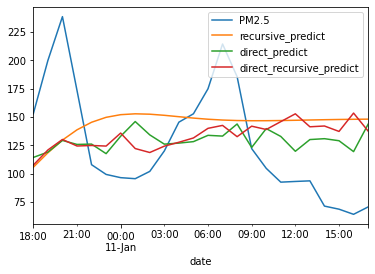

In [60]:
test.plot()

In [61]:
rmse = sqrt(mean_squared_error(test['PM2.5'], test['direct_recursive_predict']))
print(rmse)

53.33013629855533


In [62]:
test

,PM2.5,recursive_predict,direct_predict,direct_recursive_predict
date,,,,
2020-01-10 18:00:00,152.82,105.583450,114.245677,107.471360
2020-01-10 19:00:00,199.75,118.335220,118.955459,120.804377
2020-01-10 20:00:00,238.45,129.547570,129.232630,130.088718
2020-01-10 21:00:00,173.36,138.593959,125.714647,124.316976
2020-01-10 22:00:00,107.83,145.263503,126.006795,124.781299
2020-01-10 23:00:00,99.25,149.623076,117.569168,124.268948
2020-01-11 00:00:00,96.39,151.963685,132.932914,135.728972
2020-01-11 01:00:00,95.48,152.720466,145.897469,122.077456
2020-01-11 02:00:00,101.92,152.382561,134.124635,118.583502


# MIMO

In [63]:
def generate_data(data, n_input, n_output):
    X, y = [], []
    for i in range(0,len(data)-(n_input+n_output)):
            X.append(data[i:(i+n_input)])
            y.append(data[i+n_input: i+n_input+n_output])
    return np.array(X), np.array(y)

In [64]:
n_input = 24
n_features = 1
n_output = len(scaled_test)

X, y = generate_data(scaled_train, n_input, n_output)

In [65]:
model = Sequential()
model.add(LSTM(200, activation='relu', input_shape=(n_input, n_features)))
model.add(Dense(n_output))
model.compile(optimizer='adam', loss='mse')

In [66]:
model.fit(X, y, epochs=3, verbose=0)

In [67]:
model.summary()

Model: "sequential_49"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_49 (LSTM)               (None, 200)               161600    
_________________________________________________________________
dense_49 (Dense)             (None, 24)                4824      
Total params: 166,424
Trainable params: 166,424
Non-trainable params: 0
_________________________________________________________________


In [68]:
tX = scaled_train[-n_input:]
tX = tX.reshape((1, tX.shape[0], n_features))

res = model.predict(tX)

res = res.reshape((res.shape[1],1))

In [69]:
res.shape

(24, 1)

In [70]:
true_predictions = scaler.inverse_transform(res)

test['MIMO_predict'] = true_predictions

In [71]:
test

,PM2.5,recursive_predict,direct_predict,direct_recursive_predict,MIMO_predict
date,,,,,
2020-01-10 18:00:00,152.82,105.583450,114.245677,107.471360,148.848694
2020-01-10 19:00:00,199.75,118.335220,118.955459,120.804377,142.164658
2020-01-10 20:00:00,238.45,129.547570,129.232630,130.088718,146.125961
2020-01-10 21:00:00,173.36,138.593959,125.714647,124.316976,147.734665
2020-01-10 22:00:00,107.83,145.263503,126.006795,124.781299,147.201920
2020-01-10 23:00:00,99.25,149.623076,117.569168,124.268948,153.053894
2020-01-11 00:00:00,96.39,151.963685,132.932914,135.728972,144.696899
2020-01-11 01:00:00,95.48,152.720466,145.897469,122.077456,139.798447
2020-01-11 02:00:00,101.92,152.382561,134.124635,118.583502,146.829987


<AxesSubplot:xlabel='date'>

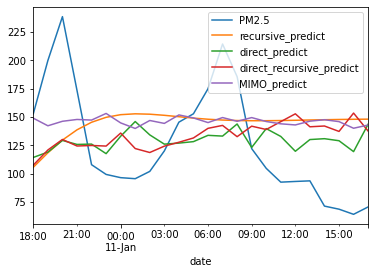

In [72]:
test.plot()

In [73]:
rmse = sqrt(mean_squared_error(test['PM2.5'], test['MIMO_predict']))
print(rmse)

51.51539939361756


# Direct MIMO

In [74]:
def generate_data(data, n_input, q_no, n_output):
    X, y = [], []
    for i in range(0,len(data)-(n_input + ((q_no-1)*n_output) + n_output)):
            X.append(data[i:(i+n_input)])
            y.append(data[i+n_input+((q_no-1)*n_output): i+n_input+((q_no-1)*n_output) + n_output])
    return np.array(X), np.array(y)

In [75]:
def model_predict(train_data, n_input, n_features, q_no, n_output):
    
    model = Sequential()
    model.add(LSTM(200, activation='relu', input_shape=(n_input, n_features)))
    model.add(Dense(n_output))
    model.compile(optimizer='adam', loss='mse')
    
    X, y = generate_data(train_data, n_input, q_no, n_output)
    
    model.fit(X, y, epochs=3, verbose=0)
    
    tX = train_data[-n_input:]
    
    tX = tX.reshape((1, n_input, n_features))
    
    res = model.predict(tX)
    
    return res

In [76]:
n_input = 12
n_features = 1
test_predictions = []

n_output = 6

q = int(len(scaled_test)/n_output)


for i in range(q):
    pred = model_predict(scaled_train,n_input, n_features, i+1, n_output)
    test_predictions.append(pred)

test_predictions

[array([[0.2418179 , 0.25553232, 0.24042127, 0.26989415, 0.25625068,
         0.27997467]], dtype=float32),
 array([[0.25437278, 0.25417256, 0.24648672, 0.25615752, 0.23856471,
         0.2518484 ]], dtype=float32),
 array([[0.29878452, 0.30159456, 0.28396994, 0.28997484, 0.2907994 ,
         0.28226757]], dtype=float32),
 array([[0.27804273, 0.27818277, 0.26352087, 0.2568782 , 0.25896114,
         0.2583257 ]], dtype=float32)]

In [77]:
res = []

for i in test_predictions:
    for j in i:
        for k in j:
            res.append(k)

In [78]:
res = np.array(res[:len(scaled_test)])
res = res.reshape((res.shape[0],1))
res.shape

(24, 1)

In [79]:
true_predictions = scaler.inverse_transform(res)

test['Direct_MIMO_predict'] = true_predictions

In [80]:
test

,PM2.5,recursive_predict,direct_predict,direct_recursive_predict,MIMO_predict,Direct_MIMO_predict
date,,,,,,
2020-01-10 18:00:00,152.82,105.583450,114.245677,107.471360,148.848694,122.048576
2020-01-10 19:00:00,199.75,118.335220,118.955459,120.804377,142.164658,127.050079
2020-01-10 20:00:00,238.45,129.547570,129.232630,130.088718,146.125961,121.539230
2020-01-10 21:00:00,173.36,138.593959,125.714647,124.316976,147.734665,132.287704
2020-01-10 22:00:00,107.83,145.263503,126.006795,124.781299,147.201920,127.312057
2020-01-10 23:00:00,99.25,149.623076,117.569168,124.268948,153.053894,135.963959
2020-01-11 00:00:00,96.39,151.963685,132.932914,135.728972,144.696899,126.627205
2020-01-11 01:00:00,95.48,152.720466,145.897469,122.077456,139.798447,126.554192
2020-01-11 02:00:00,101.92,152.382561,134.124635,118.583502,146.829987,123.751244


<AxesSubplot:xlabel='date'>

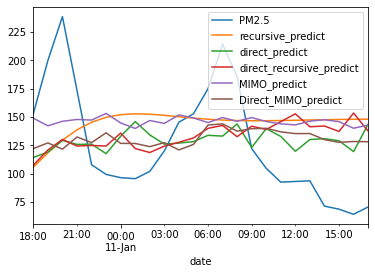

In [81]:
test.plot()

In [82]:
rmse = sqrt(mean_squared_error(test['PM2.5'], test['Direct_MIMO_predict']))
print(rmse)

48.629391665557684


In [83]:
rec_err = abs(test['PM2.5'] - test['recursive_predict'])
dir_err = abs(test['PM2.5'] - test['direct_predict'])
dir_rec_err = abs(test['PM2.5'] - test['direct_recursive_predict'])
mimo_err = abs(test['PM2.5'] - test['MIMO_predict'])
dir_mimo_err = abs(test['PM2.5'] - test['Direct_MIMO_predict'])

In [84]:
errors = pd.DataFrame({
    'Recursive':rec_err,
    'Direct':dir_err,
    'Direct Recursive':dir_rec_err,
    'MIMO':mimo_err,
    'Direct MIMO':dir_mimo_err
})

In [85]:
errors

,Recursive,Direct,Direct Recursive,MIMO,Direct MIMO
date,,,,,
2020-01-10 18:00:00,47.236550,38.574323,45.348640,3.971306,30.771424
2020-01-10 19:00:00,81.414780,80.794541,78.945623,57.585342,72.699921
2020-01-10 20:00:00,108.902430,109.217370,108.361282,92.324039,116.910770
2020-01-10 21:00:00,34.766041,47.645353,49.043024,25.625335,41.072296
2020-01-10 22:00:00,37.433503,18.176795,16.951299,39.371920,19.482057
2020-01-10 23:00:00,50.373076,18.319168,25.018948,53.803894,36.713959
2020-01-11 00:00:00,55.573685,36.542914,39.338972,48.306899,30.237205
2020-01-11 01:00:00,57.240466,50.417469,26.597456,44.318447,31.074192
2020-01-11 02:00:00,50.462561,32.204635,16.663502,44.909987,21.831244


<AxesSubplot:xlabel='date'>

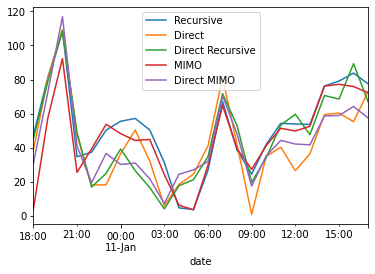

In [86]:
errors.plot()

In [87]:
len(scaled_test)

24